<a href="https://colab.research.google.com/github/BATiger/Classic/blob/main/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [ ]:
class AlexNet(nn.Module):
    def __init__(self, drop_out=0.2, number_class = 1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # conv1
            nn.Conv2d(3,96,kernel_size = 11,stride = 4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            
            # conv2
            nn.Conv2d(96,256,kernel_size = 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),
            
            # conv3
            nn.Conv2d(256,384,kernel_size = 3, padding=1),
            nn.ReLU(),
            
            # conv4
            nn.Conv2d(384,384,kernel_size = 3, padding=1),
            nn.ReLU(),
            
            # conv5
            nn.Conv2d(384,256,kernel_size = 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2)
        )

        #对于classifier进行一些简化
        self.classifier = nn.Sequential(
            nn.Linear(9216, 4096),
            nn.Dropout(drop_out),
            nn.Linear(4096, 1000),
            nn.Dropout(drop_out),
            nn.Linear(1000, number_class)
        )
    
    def forward(self, input):
        x = self.features(input)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

In [ ]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.RandomCrop(224),
   transforms.RandomHorizontalFlip()
])

In [ ]:
batch_size = 128

# there should be 9469 images in training data and 3925 images in test data
train_dir = 'drive/My Drive/ClassicCode/ImageNetSub/train'
train_datasets = datasets.ImageFolder(train_dir, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = 'drive/My Drive/ClassicCode/ImageNetSub/val'
val_datasets = datasets.ImageFolder(val_dir, transform=transform)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

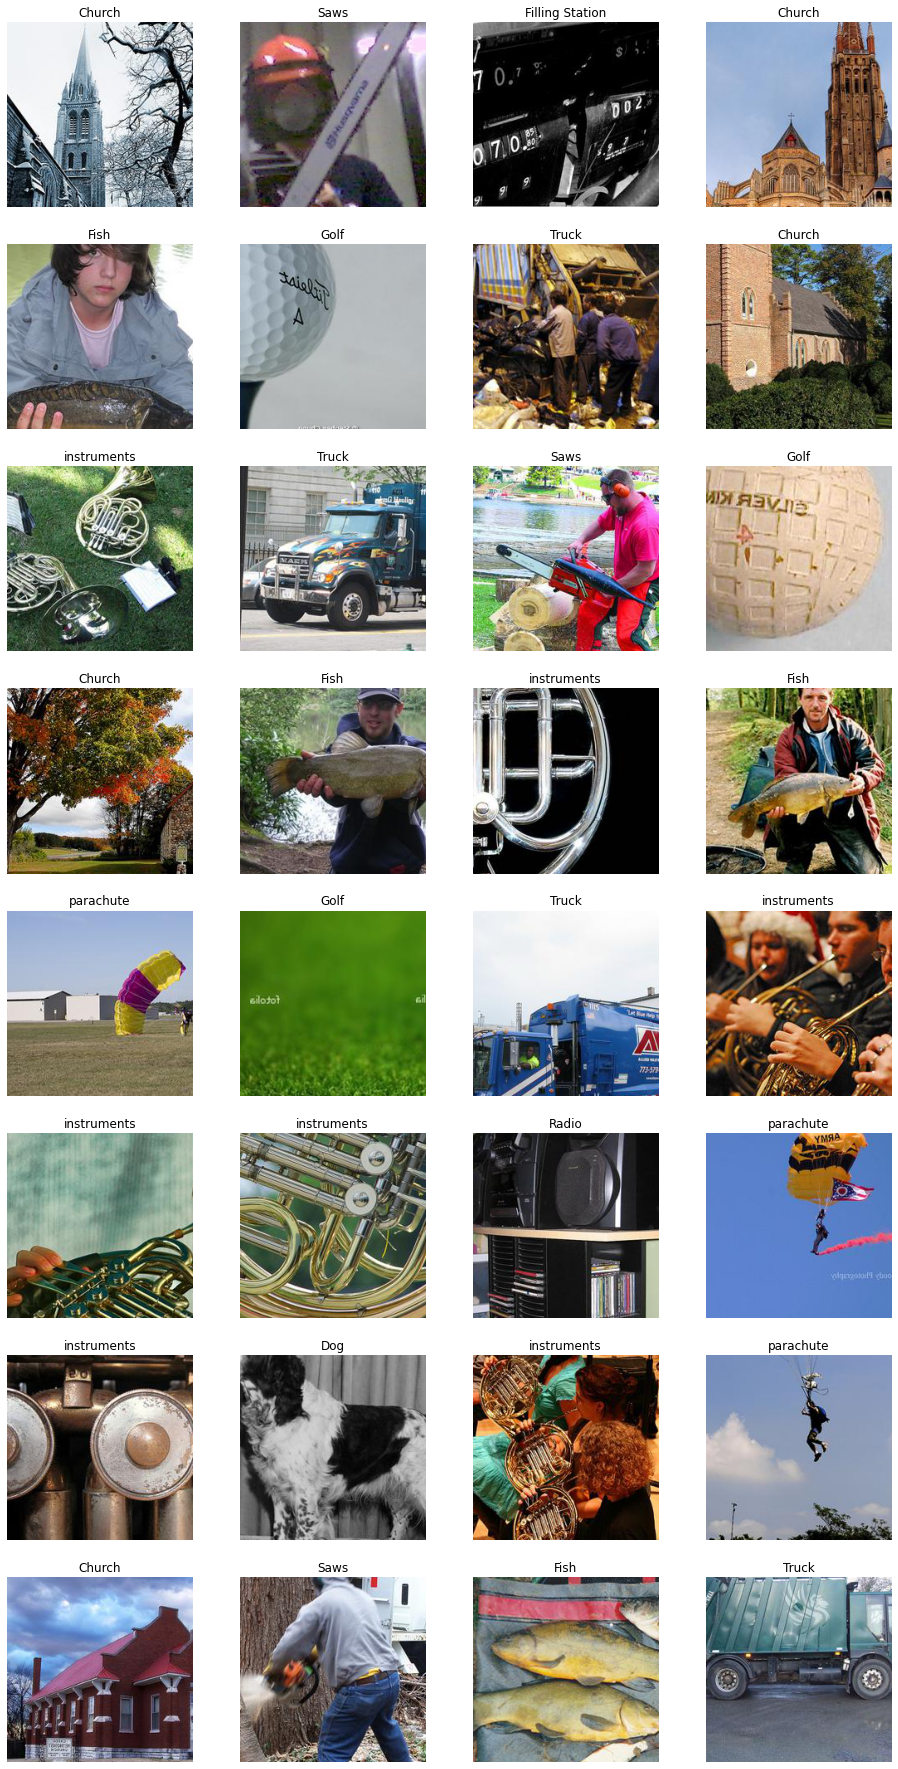

In [ ]:
# visualize images in the first batch

labels_map = {
    0: "Fish",
    1: "Dog",
    2: "Radio",
    3: "Saws",
    4: "Church",
    5: "instruments",
    6: "Truck",
    7: "Filling Station",
    8: "Golf",
    9: "parachute",
}

imgs, labels = next(iter(train_dataloader))


figure = plt.figure(figsize=(16, 32))
cols, rows = 4, 8
for i in range(1, cols * rows + 1):
    img = imgs[i-1]
    label = labels[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label.item()])
    plt.axis("off")
    plt.imshow((img.permute(1, 2, 0) ))
plt.show()

In [ ]:
# hyper-parameters
epochs = 20
learning_rate = 0.002
GPU = True

In [ ]:
# choose device
print(torch.cuda.is_available())
if GPU:
    device = torch.device("cuda")

True


In [ ]:
model = AlexNet(number_class=10).to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.CrossEntropyLoss()


for epoch in range(epochs):
    count = 0
    print('epoch {}'.format(epoch + 1))
    # training------------------------------------------
    train_loss = 0
    train_acc = 0
    for x,y in train_dataloader:
        x,y = x.to(device), y.to(device)
        output = model(x)
        loss = criterion(output, y)

        train_loss += loss.item()
        # torch.max 返回 (1)最大值 (2)最大值的index 这里要的是index
        pred = torch.max(output,1)[1]
        
        train_correct = (pred == y).sum()
        train_acc += train_correct.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count = count+1

    # 打印每一个epoch的结果
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / count, train_acc / (len(train_datasets))))        

epoch 1
Train Loss: 4.630865, Acc: 0.101489
epoch 2
Train Loss: 2.306040, Acc: 0.101489
epoch 3
Train Loss: 2.306798, Acc: 0.096948
epoch 4
Train Loss: 2.304674, Acc: 0.098004
epoch 5
Train Loss: 2.304356, Acc: 0.097476
epoch 6
Train Loss: 2.303702, Acc: 0.099799
epoch 7
Train Loss: 2.304118, Acc: 0.100011
epoch 8
Train Loss: 2.304867, Acc: 0.093991
epoch 9
Train Loss: 2.303899, Acc: 0.098321
epoch 10
Train Loss: 2.304459, Acc: 0.103918
epoch 11
Train Loss: 2.306602, Acc: 0.100222
epoch 12
Train Loss: 2.305367, Acc: 0.100644
epoch 13
Train Loss: 2.304324, Acc: 0.102440
epoch 14
Train Loss: 2.305577, Acc: 0.100011
epoch 15
Train Loss: 2.303916, Acc: 0.104024
epoch 16
Train Loss: 2.304107, Acc: 0.097793
epoch 17
Train Loss: 2.305252, Acc: 0.101383
epoch 18
Train Loss: 2.303850, Acc: 0.102123
epoch 19
Train Loss: 2.304900, Acc: 0.101383
epoch 20
Train Loss: 2.305981, Acc: 0.097370


In [ ]:
with torch.no_grad():
    model.eval()
    eval_loss = 0.
    eval_acc = 0.

    for x, y in val_dataloader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss =  criterion(out, y)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == y).sum()
        eval_acc += num_correct.item()
    
    print('test_loss: ', eval_loss/len(val_dataloader))
    print('test accuracy: ', eval_acc/len(val_datasets))

test_loss:  2.305085612881568
test accuracy:  0.09895700839481048
